In [47]:
#!pip -q install timm
#!pip -q install pytorch_lightning
#!pip -q install albumentations

In [48]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR
from torch.optim.optimizer import Optimizer
import torchvision.utils as vutils

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [49]:
SEED = 42
N_FOLDS = 5
TRAIN_FOLD = 3
TARGET_COL = 'target'
N_EPOCHS = 10
BATCH_SIZE = 72
IMG_SIZE = 640
LR = 1e-4
MAX_LR = 5e-4
PRECISION = 16
MODEL = 'efficientnet_b0'

In [50]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state


random_state = set_seed(SEED)

Global seed set to 42


In [51]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU not available, going to use CPU instead.")

GPU is available.


In [52]:
train = pd.read_csv('./seti-breakthrough-listen/train_labels.csv')
test = pd.read_csv('./seti-breakthrough-listen/sample_submission.csv')

def get_train_file_path(image_id):
    return "./seti-breakthrough-listen/train/{}/{}.npy".format(image_id[0], image_id)

def get_test_file_path(image_id):
    return "./seti-breakthrough-listen/test/{}/{}.npy".format(image_id[0], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.sample(5))

,id,target,file_path
4256,155e40cc7dc1,0,./seti-breakthrough-listen/train/1/155e40cc7dc...
31961,a2e3f473511c,0,./seti-breakthrough-listen/train/a/a2e3f473511...
8161,297d6cc4529f,0,./seti-breakthrough-listen/train/2/297d6cc4529...
9246,2effda776e01,0,./seti-breakthrough-listen/train/2/2effda776e0...
2885,0ed73f5f004e,0,./seti-breakthrough-listen/train/0/0ed73f5f004...


In [53]:
dist = train.target.map({0:'haystack', 1:'needle'})
dist = dist.value_counts()
fig = px.pie(dist,
             values='target',
             names=dist.index,
             hole=.4,title="Target Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

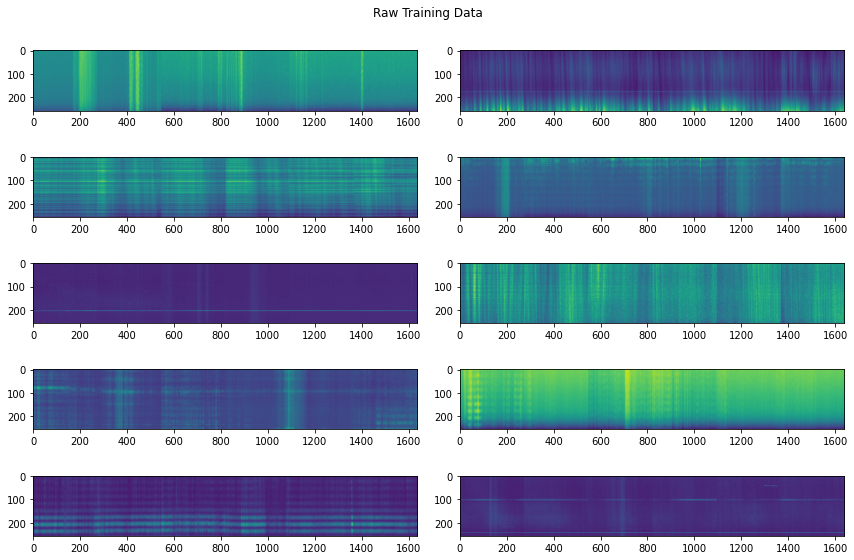

In [54]:
plt.figure(figsize=(12, 8))
for i in range(10):
    if i < 4:
        image = np.load(train.loc[i, 'file_path'])
    else:
        image = np.load(train[train['target']==1].reset_index().loc[i, 'file_path'])
    image = image.astype(np.float32)
    image = np.vstack(image).T
    plt.subplot(5, 2, i + 1)
    plt.imshow(image)
plt.suptitle("Raw Training Data")
plt.tight_layout()

In [55]:
class TrainDataset(Dataset):
    def __init__(self, df, test=False, transform=None):
        self.df = df
        self.test = test
        self.file_names = df['file_path'].values
        if not self.test:
            self.labels = df[TARGET_COL].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        
        image = np.load(file_path)[[0, 2, 4]] 
        image = image.astype(np.float32)
        image = np.vstack(image).T 
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        if not self.test:
            label = torch.unsqueeze(torch.tensor(self.labels[idx]).float(),-1)
            return image, label
        else:
            return image

In [56]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(IMG_SIZE,
                    IMG_SIZE),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            ToTensorV2(),
        ])

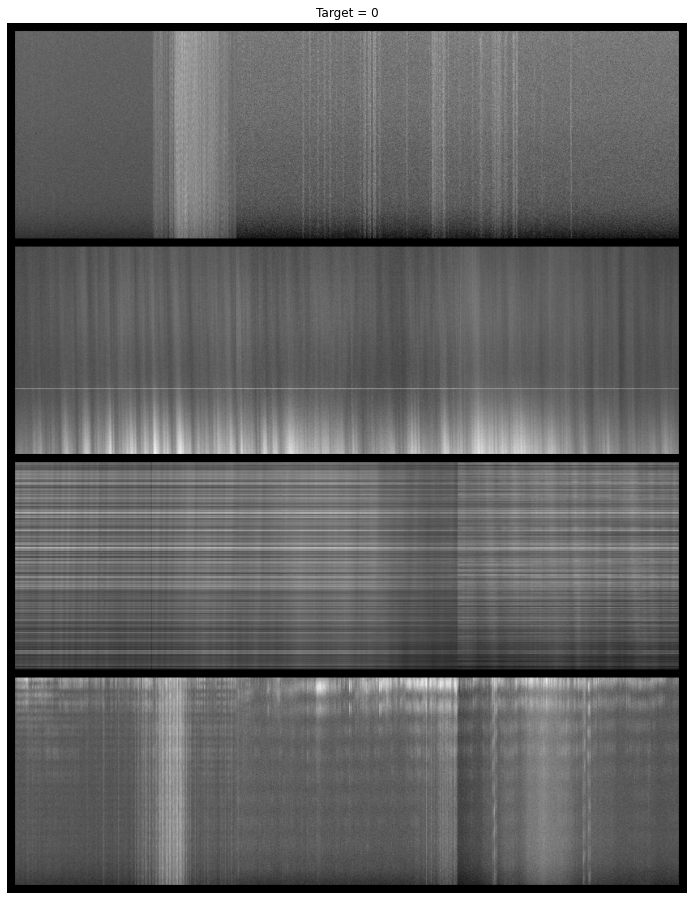

In [57]:
def train_dataloader():
    return DataLoader(train_dataset, batch_size=4, num_workers=2,
                      drop_last=False, shuffle=False, pin_memory=True)
train_dataset = TrainDataset(train[train['target']==0], transform=None)
batch, targets = next(iter(train_dataloader()))

plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Target = 0")
plt.imshow(vutils.make_grid(
    batch, nrow=1, padding=10, normalize=True).permute(1,2,0).cpu().numpy())
plt.show()

In [58]:
class DataModule(pl.LightningDataModule):

    def __init__(self, train_df, val_df, test_df,  batch_size=BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    def setup(self, stage=None):
        self.train_dataset = TrainDataset(
          self.train_df,
          transform=get_transforms(data='train')
            
        )
        
        self.val_dataset = TrainDataset(          
          self.val_df,
          transform=get_transforms(data='valid')
        )

        self.test_dataset = TrainDataset(
          self.test_df,
          transform=get_transforms(data='valid'),
          test = True
        )

    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size=self.batch_size,
          shuffle=True,
          num_workers=4,
          pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
          self.val_dataset,
          batch_size=self.batch_size,
          num_workers=4,
          pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
          self.test_dataset,
          batch_size=self.batch_size,
          num_workers=4,
          pin_memory=True
        )

In [59]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [60]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

In [61]:
class Predictor(pl.LightningModule):

    def __init__(self, n_classes: int, n_training_steps=None, steps_per_epoch=None):
        super().__init__()
        self.n_classes = n_classes
        self.model = timm.create_model(MODEL, pretrained=True, in_chans=1)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, n_classes)
        self.n_training_steps = n_training_steps
        self.steps_per_epoch = steps_per_epoch

    def forward(self, x):
        output = self.model(x)
        return output


    def training_step(self, batch, batch_idx):

        x, y = batch
        
        x, y_a, y_b, lam = mixup_data(x, y.view(-1, 1))
        
        output = self(x)
        labels = y
        loss = mixup_criterion(criterion, output, y_a, y_b, lam)
        try:
            auc=roc_auc_score(labels.detach().cpu(), output.sigmoid().detach().cpu())        
            self.log("auc", auc, prog_bar=True, logger=True)
        except:
            pass
        return {"loss": loss, "predictions": output, "labels": labels}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        labels = y
        loss = criterion(output, y)
        try:
            auc=roc_auc_score(labels.detach().cpu(), output.sigmoid().detach().cpu())        
            self.log("val_auc", auc, prog_bar=True, logger=True)
        except:
            pass
        return loss

    def test_step(self, batch, batch_idx):
        x = batch        
        output = self(x).sigmoid()
        return output   



    def configure_optimizers(self):

        optimizer = MADGRAD(self.parameters(), lr=LR)

        scheduler = OneCycleLR(
          optimizer,
          epochs = N_EPOCHS,
          max_lr = MAX_LR,
          total_steps = self.n_training_steps,
          steps_per_epoch = self.steps_per_epoch
        )

        return dict(
          optimizer=optimizer,
          lr_scheduler=scheduler
        )

In [62]:
t_steps_per_epoch=(len(train)// N_EPOCHS) // BATCH_SIZE
print(t_steps_per_epoch)
total_training_steps = t_steps_per_epoch * N_EPOCHS
print(total_training_steps)
criterion=nn.BCEWithLogitsLoss()

69
690


In [63]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
train["fold"] = -1
for fold_id, (_, val_idx) in enumerate(skf.split(train["id"], train["target"])):
    train.loc[val_idx, "fold"] = fold_id
    
    
model = Predictor(steps_per_epoch=t_steps_per_epoch,
                  n_training_steps=total_training_steps ,
                  n_classes=1
    )


data_module = DataModule(
  train[train['fold']!=TRAIN_FOLD], # train fold
  train[train['fold']==TRAIN_FOLD], # val fold
  train[train['fold']==TRAIN_FOLD], # test data, same as val for now
  batch_size=BATCH_SIZE,
)
early_stopping_callback = EarlyStopping(monitor='val_auc',mode="max", patience=2)
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint-ep{epoch:02d}-{val_auc:.3f}",
  save_top_k = 1,
  verbose = True,
  monitor = "val_auc",
  mode="max"
)
trainer = pl.Trainer(
  checkpoint_callback= True,
  callbacks=[early_stopping_callback,checkpoint_callback],
  max_epochs=N_EPOCHS,
  gpus=4,
  accelerator="dp",
  precision=PRECISION,
  progress_bar_refresh_rate=5
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

Checkpoint directory checkpoints exists and is not empty.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [64]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 4.0 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.033    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 557: val_auc reached 0.95118 (best 0.95118), saving model to "/nfs/Workspace/checkpoints/best-checkpoint-epepoch=00-val_auc=0.951.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1115: val_auc reached 0.97021 (best 0.97021), saving model to "/nfs/Workspace/checkpoints/best-checkpoint-epepoch=01-val_auc=0.970.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1673: val_auc reached 0.98223 (best 0.98223), saving model to "/nfs/Workspace/checkpoints/best-checkpoint-epepoch=02-val_auc=0.982.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 2231: val_auc was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 2789: val_auc was not in top 1


In [65]:
# get trained model
trained_model = Predictor.load_from_checkpoint(
  trainer.callbacks[-1].best_model_path,
  n_classes=1)
trained_model.eval()
trained_model.freeze()
trained_model = trained_model.to(device)

# get_predictions
def get_predictions(df):
    predictions = []
    val_dataset = TrainDataset(df,
                               transform=get_transforms(data='valid'),
                               test = True)
    dataloader=DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
    for item in tqdm(dataloader, position=0, leave=True):
        prediction = trained_model(item.to(device))
        predictions.append(prediction.flatten().sigmoid())
    predictions = torch.cat(predictions).detach().cpu()
    final_preds=predictions.squeeze(-1).numpy()
    return final_preds

oof_train_preds = get_predictions(train[train['fold']==TRAIN_FOLD])
final_preds = get_predictions(test)

100%|██████████| 281/281 [01:45<00:00,  2.66it/s]


# oof

In [66]:
oof = train[train['fold']==TRAIN_FOLD]
oof['preds'] = oof_train_preds
oof

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,target,file_path,fold,preds
1,0004300a0b9b,0,./seti-breakthrough-listen/train/0/0004300a0b9...,3,0.017906
10,000aa7a1875d,0,./seti-breakthrough-listen/train/0/000aa7a1875...,3,0.008622
19,001a18d3a379,0,./seti-breakthrough-listen/train/0/001a18d3a37...,3,0.006495
20,001c619bdf53,1,./seti-breakthrough-listen/train/0/001c619bdf5...,3,0.739167
22,001f5ee68804,0,./seti-breakthrough-listen/train/0/001f5ee6880...,3,0.002909
...,...,...,...,...,...
50121,ffbeaf20de6d,0,./seti-breakthrough-listen/train/f/ffbeaf20de6...,3,0.008348
50126,ffc6c104cfa2,0,./seti-breakthrough-listen/train/f/ffc6c104cfa...,3,0.009767
50130,ffcc44f9a7a5,0,./seti-breakthrough-listen/train/f/ffcc44f9a7a...,3,0.006399
50138,ffd8142fb1ee,0,./seti-breakthrough-listen/train/f/ffd8142fb1e...,3,0.004747


In [67]:
oof.to_csv(f'oof_seed{SEED}_fold{TRAIN_FOLD}.csv', index=False)

# sub

In [68]:
submission = pd.read_csv('./seti-breakthrough-listen/sample_submission.csv')
submission['target'] = final_preds
submission.head()

,id,target
0,00034db451c4,0.034137
1,0006316b5ca0,0.006374
2,0006a953d21b,0.046795
3,0008a33d6695,0.038863
4,00095b5119fc,0.006217


In [69]:
submission.to_csv(f'sub_seed{SEED}_fold{TRAIN_FOLD}.csv', index=False)